# UNISURF Dataset Processing.

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook contains an example workflow for converting a video file to a Nerfies dataset.

### Instructions

1. Convert a video into our dataset format using this notebook. OR Convert a directory of images into a video that can then be converted into our dataset format.
2. Train a NLR using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb).

NOTE: UNISURF preprocessing, we require masks to be provided. 


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power.
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately.
* Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

If you find this work useful, please consider citing:
```bibtex
@article{park2021nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Nerfies: Deformable Neural Radiance Fields},
  journal   = {ICCV},
  year      = {2021},
}
```

## Install dependencies.

In [ ]:
!apt-get install colmap ffmpeg

!pip install numpy==1.19.3
!pip install mediapipe
!pip install tensorflow_graphics
!pip install git+https://github.com/google/nerfies.git@v2
!pip install "git+https://github.com/google/nerfies.git#egg=pycolmap&subdirectory=third_party/pycolmap"

## Make a Video.

Creates a video out of images in a given folder at 1 fps

In [ ]:
import cv2
import os

# @markdown The directory containing all the RGB PNG images of your dataset.
image_folder = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan55-og' # @param {type: 'string'}
# @markdown The directory containing all the mask PNG images of your dataset.
mask_folder = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan55-og' # @param {type: 'string'}
dim = (800,600) # w by h
avi_file_path = os.path.join(image_folder, 'video.avi')
mp4_name = os.path.join(image_folder, 'video')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith("_rgb.png")]
if len(images) > 100:
    images = images[:100]
frame = cv2.imread(os.path.join(image_folder, images[0]))

video = cv2.VideoWriter(avi_file_path, 0, 1, dim)

for image in images:
    video.write(cv2.resize(cv2.imread(os.path.join(image_folder, image)), dim, interpolation = cv2.INTER_AREA))

# cv2.destroyAllWindows()
video.release()

# def convert_avi_to_mp4(avi_file_path, output_name):
os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input = avi_file_path, output = mp4_name))
mp4_name = mp4_name + '.mp4'


In [2]:
# @title Configure dataset directories
from pathlib import Path

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name` in which the Nerfies version of the dataset will be stored. **Make sure you change this** when processing a new video.
capture_name = 'scan55'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'
# Where to save masks.
mask_dir = root_dir / 'rgb' / 'mask'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)
mask_dir.mkdir(exist_ok=True, parents=True)

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
  mask_dir = {mask_dir}
""")

Directories configured:
  root_dir = /ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan55
  rgb_raw_dir = /ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan55/rgb-raw
  rgb_dir = /ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan55/rgb
  colmap_dir = /ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan55/colmap
  mask_dir = /ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan55/rgb/mask



## Dataset Processing.

In [ ]:
# @title Upload video file.
# @markdown Select a video file (.mp4, .mov, etc.) from your disk. This will upload it to the local Colab working directory.
from google.colab import files

uploaded = files.upload()

### Move Masks.

In this step we copy and resize exisiting mask PNG images to the mask directory under RGB.

In [ ]:
# @title reshape and move pre-existing masks.
from PIL import Image
 
i = 1
for file in sorted(os.listdir(mask_folder)):
    f_img = mask_folder+"/"+file

    if os.path.isfile(f_img) and file[-9:] == '.png':
        # print(file)
        img = Image.open(f_img)
        img = img.resize(dim)
        img.save(str(mask_dir)+'/'+str(i).zfill(6)+'.png')
        i = i + 1
        


### Load Video.

In this step we load the video file and flatten it into PNG files using ffmpeg. If starting with images, use 1 fps.

In [ ]:
# @title Flatten into images.

import cv2


# @markdown Flattens the video into images. The results will be saved to `rgb_raw_dir`.
video_path = mp4_name

# @markdown Adjust `max_scale` to something smaller for faster processing.
max_scale = 1 #0.9803921568627451  # @param {type:'number'}
# @markdown A smaller FPS will be much faster for bundle adjustment, but at the expensive of a lower sampling density for training. For the paper we used ~15 fps but we default to something lower here to get you started faster.
# @markdown If given an fps of -1 we will try to auto-compute it.
fps = 1  # @param {type:'number'}
target_num_frames = 49 # @param {type: 'number'}

cap = cv2.VideoCapture(video_path)
input_fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if num_frames < target_num_frames:
  raise RuntimeError(
      'The video is too short and has fewer frames than the target.')

if fps == -1:
  fps = int(target_num_frames / num_frames * input_fps)
  print(f"Auto-computed FPS = {fps}")

# @markdown Check this if you want to reprocess the frames.
overwrite = True  # @param {type:'boolean'}

if (rgb_dir / '1x').exists() and not overwrite:
  raise RuntimeError(
      f'The RGB frames have already been processed. Check `overwrite` and run again if you really meant to do this.')
else:
  filters = f"mpdecimate,setpts=N/FRAME_RATE/TB,scale=iw*{max_scale}:ih*{max_scale}"
  tmp_rgb_raw_dir = 'rgb-raw'
  out_pattern = str('rgb-raw/%06d.png')
  !mkdir -p "$tmp_rgb_raw_dir"
  !rm -rf $tmp_rgb_raw_dir/*
  !rm -rf $rgb_raw_dir/*
  !ffmpeg -i "$video_path" -r $fps -vf $filters "$out_pattern"
  !mkdir -p "$rgb_raw_dir"
  !rsync -av "$tmp_rgb_raw_dir/" "$rgb_raw_dir/"

In [ ]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

tmp_rgb_dir = Path('rgb')
!rm -rf $tmp_rgb_dir/*

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        tmp_rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

!rsync -av "$tmp_rgb_dir/" "$rgb_dir/"


In [ ]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

from pathlib import Path
import imageio
from PIL import Image

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

### Camera registration with COLMAP.

In [ ]:
# @title Extract features.
# @markdown Computes SIFT features and saves them to the COLMAP DB.
share_intrinsics = True  # @param {type: 'boolean'}
assume_upright_cameras = True  # @param {type: 'boolean'}

# @markdown This sets the scale at which we will run COLMAP. A scale of 1 will be more accurate but will be slow.
colmap_image_scale = 1  # @param {type: 'number'}
colmap_rgb_dir = rgb_dir / f'{colmap_image_scale}x'

# @markdown Check this if you want to re-process SfM.
overwrite = False  # @param {type: 'boolean'}

if overwrite and colmap_db_path.exists():
  colmap_db_path.unlink()
print(str(colmap_rgb_dir))
!colmap feature_extractor \
--SiftExtraction.use_gpu 1 \
--SiftExtraction.upright {int(assume_upright_cameras)} \
--ImageReader.camera_model OPENCV \
--ImageReader.single_camera {int(share_intrinsics)} \
--database_path "{str(colmap_db_path)}" \
--image_path "{str(colmap_rgb_dir)}" \
--ImageReader.mask_path "{str(mask_dir)}"

In [ ]:
# @title Match features.
# @markdown Match the SIFT features between images. Use `exhaustive` if you only have a few images and use `vocab_tree` if you have a lot of images.

match_method = 'vocab_tree'  # @param ["exhaustive", "vocab_tree"]

if match_method == 'exhaustive':
  !colmap exhaustive_matcher \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"
else:
  # Use this if you have lots of frames.
  !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
  !colmap vocab_tree_matcher \
    --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"

In [ ]:
# @title Reconstruction.
# @markdown Run structure-from-motion to compute camera parameters.

refine_principal_point = True  #@param {type:"boolean"}
min_num_matches =   32# @param {type: 'number'}
filter_max_reproj_error = 2  # @param {type: 'number'}
tri_complete_max_reproj_error = 2  # @param {type: 'number'}

!colmap mapper \
  --Mapper.ba_refine_principal_point {int(refine_principal_point)} \
  --Mapper.filter_max_reproj_error $filter_max_reproj_error \
  --Mapper.tri_complete_max_reproj_error $tri_complete_max_reproj_error \
  --Mapper.min_num_matches $min_num_matches \
  --database_path "{str(colmap_db_path)}" \
  --image_path "{str(colmap_rgb_dir)}" \
  --output_path "{str(colmap_out_path)}"

In [ ]:
# @title Verify that SfM worked.

if not colmap_db_path.exists():
  raise RuntimeError(f'The COLMAP DB does not exist, did you run the reconstruction?')
elif not (colmap_dir / 'sparse/0/cameras.bin').exists():
  raise RuntimeError("""
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.
""")
else:
  print("Everything looks good!")

## Parse Data.

In [ ]:
# @title Define Scene Manager.
from absl import logging
from typing import Dict
import numpy as np
from nerfies.camera import Camera
import pycolmap
from pycolmap import Quaternion


def convert_colmap_camera(colmap_camera, colmap_image):
  """Converts a pycolmap `image` to an SFM camera."""
  camera_rotation = colmap_image.R()
  camera_position = -(colmap_image.t @ camera_rotation)
  new_camera = Camera(
      orientation=camera_rotation,
      position=camera_position,
      focal_length=colmap_camera.fx,
      pixel_aspect_ratio=colmap_camera.fx / colmap_camera.fx,
      principal_point=np.array([colmap_camera.cx, colmap_camera.cy]),
      radial_distortion=np.array([colmap_camera.k1, colmap_camera.k2, 0.0]),
      tangential_distortion=np.array([colmap_camera.p1, colmap_camera.p2]),
      skew=0.0,
      image_size=np.array([colmap_camera.width, colmap_camera.height])
  )
  return new_camera


def filter_outlier_points(points, inner_percentile):
  """Filters outlier points."""
  outer = 1.0 - inner_percentile
  lower = outer / 2.0
  upper = 1.0 - lower
  centers_min = np.quantile(points, lower, axis=0)
  centers_max = np.quantile(points, upper, axis=0)
  result = points.copy()

  too_near = np.any(result < centers_min[None, :], axis=1)
  too_far = np.any(result > centers_max[None, :], axis=1)

  return result[~(too_near | too_far)]


def average_reprojection_errors(points, pixels, cameras):
  """Computes the average reprojection errors of the points."""
  cam_errors = []
  for i, camera in enumerate(cameras):
    cam_error = reprojection_error(points, pixels[:, i], camera)
    cam_errors.append(cam_error)
  cam_error = np.stack(cam_errors)

  return cam_error.mean(axis=1)


def _get_camera_translation(camera):
  """Computes the extrinsic translation of the camera."""
  rot_mat = camera.orientation
  return -camera.position.dot(rot_mat.T)


def _transform_camera(camera, transform_mat):
  """Transforms the camera using the given transformation matrix."""
  # The determinant gives us volumetric scaling factor.
  # Take the cube root to get the linear scaling factor.
  scale = np.cbrt(linalg.det(transform_mat[:, :3]))
  quat_transform = ~Quaternion.FromR(transform_mat[:, :3] / scale)

  translation = _get_camera_translation(camera)
  rot_quat = Quaternion.FromR(camera.orientation)
  rot_quat *= quat_transform
  translation = scale * translation - rot_quat.ToR().dot(transform_mat[:, 3])
  new_transform = np.eye(4)
  new_transform[:3, :3] = rot_quat.ToR()
  new_transform[:3, 3] = translation

  rotation = rot_quat.ToR()
  new_camera = camera.copy()
  new_camera.orientation = rotation
  new_camera.position = -(translation @ rotation)
  return new_camera


def _pycolmap_to_sfm_cameras(manager: pycolmap.SceneManager) -> Dict[int, Camera]:
  """Creates SFM cameras."""
  # Use the original filenames as indices.
  # This mapping necessary since COLMAP uses arbitrary numbers for the
  # image_id.
  image_id_to_colmap_id = {
      image.name.split('.')[0]: image_id
      for image_id, image in manager.images.items()
  }

  sfm_cameras = {}
  for image_id in image_id_to_colmap_id:
    colmap_id = image_id_to_colmap_id[image_id]
    image = manager.images[colmap_id]
    camera = manager.cameras[image.camera_id]
    sfm_cameras[image_id] = convert_colmap_camera(camera, image)

  return sfm_cameras


class SceneManager:
  """A thin wrapper around pycolmap."""

  @classmethod
  def from_pycolmap(cls, colmap_path, image_path, min_track_length=10):
    """Create a scene manager using pycolmap."""
    manager = pycolmap.SceneManager(str(colmap_path))
    manager.load_cameras()
    manager.load_images()
    manager.load_points3D()
    manager.filter_points3D(min_track_len=min_track_length)
    sfm_cameras = _pycolmap_to_sfm_cameras(manager)
    return cls(sfm_cameras, manager.get_filtered_points3D(), image_path)

  def __init__(self, cameras, points, image_path):
    self.image_path = Path(image_path)
    self.camera_dict = cameras
    self.points = points

    logging.info('Created scene manager with %d cameras', len(self.camera_dict))

  def __len__(self):
    return len(self.camera_dict)

  @property
  def image_ids(self):
    return sorted(self.camera_dict.keys())

  @property
  def camera_list(self):
    return [self.camera_dict[i] for i in self.image_ids]

  @property
  def camera_positions(self):
    """Returns an array of camera positions."""
    return np.stack([camera.position for camera in self.camera_list])

  def load_image(self, image_id):
    """Loads the image with the specified image_id."""
    path = self.image_path / f'{image_id}.png'
    with path.open('rb') as f:
      return imageio.imread(f)

  def triangulate_pixels(self, pixels):
    """Triangulates the pixels across all cameras in the scene.

    Args:
      pixels: the pixels to triangulate. There must be the same number of pixels
        as cameras in the scene.

    Returns:
      The 3D points triangulated from the pixels.
    """
    if pixels.shape != (len(self), 2):
      raise ValueError(
          f'The number of pixels ({len(pixels)}) must be equal to the number '
          f'of cameras ({len(self)}).')

    return triangulate_pixels(pixels, self.camera_list)

  def change_basis(self, axes, center):
    """Change the basis of the scene.

    Args:
      axes: the axes of the new coordinate frame.
      center: the center of the new coordinate frame.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    transform_mat = np.zeros((3, 4))
    transform_mat[:3, :3] = axes.T
    transform_mat[:, 3] = -(center @ axes)
    return self.transform(transform_mat)

  def transform(self, transform_mat):
    """Transform the scene using a transformation matrix.

    Args:
      transform_mat: a 3x4 transformation matrix representation a
        transformation.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    if transform_mat.shape != (3, 4):
      raise ValueError('transform_mat should be a 3x4 transformation matrix.')

    points = None
    if self.points is not None:
      points = self.points.copy()
      points = points @ transform_mat[:, :3].T + transform_mat[:, 3]

    new_cameras = {}
    for image_id, camera in self.camera_dict.items():
      new_cameras[image_id] = _transform_camera(camera, transform_mat)

    return SceneManager(new_cameras, points, self.image_path)

  def filter_images(self, image_ids):
    num_filtered = 0
    for image_id in image_ids:
      if self.camera_dict.pop(image_id, None) is not None:
        num_filtered += 1

    return num_filtered


In [ ]:
# @title Load COLMAP scene.
import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)

np.save(str(root_dir)+'/points.npy', scene_manager.points, allow_pickle=True)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.show()

In [ ]:
# @title Filter blurry frames.
from matplotlib import pyplot as plt
import numpy as np
import cv2

def variance_of_laplacian(image: np.ndarray) -> np.ndarray:
  """Compute the variance of the Laplacian which measure the focus."""
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return cv2.Laplacian(gray, cv2.CV_64F).var()


blur_filter_perc = 95.0 # @param {type: 'number'}
blur_filter_perc = 100.0 # @param {type: 'number'}
if blur_filter_perc > 0.0:
  image_paths = sorted(rgb_dir.iterdir())
  print('Loading images.')
  images = list(map(scene_manager.load_image, scene_manager.image_ids))
  print('Computing blur scores.')
  blur_scores = np.array([variance_of_laplacian(im) for im in images])
  blur_thres = np.percentile(blur_scores, blur_filter_perc)
  blur_filter_inds = np.where(blur_scores >= blur_thres)[0]
  blur_filter_scores = [blur_scores[i] for i in blur_filter_inds]
  blur_filter_inds = blur_filter_inds[np.argsort(blur_filter_scores)]
  blur_filter_scores = np.sort(blur_filter_scores)
  blur_filter_image_ids = [scene_manager.image_ids[i] for i in blur_filter_inds]
  print(f'Filtering {len(blur_filter_image_ids)} IDs: {blur_filter_image_ids}')
  num_filtered = scene_manager.filter_images(blur_filter_image_ids)
  print(f'Filtered {num_filtered} images')

  plt.figure(figsize=(15, 10))
  plt.subplot(121)
  plt.title('Least blurry')
  plt.imshow(images[blur_filter_inds[-1]])
  plt.subplot(122)
  plt.title('Most blurry')
  plt.imshow(images[blur_filter_inds[0]])

### Face Processing.

This section runs the optional step of computing facial landmarks for the purpose of test camera generation.

In [ ]:
import jax
from jax import numpy as jnp
from tensorflow_graphics.geometry.representation.ray import triangulate as ray_triangulate

!pip install --upgrade tensorflow-graphics-gpu
use_face = False  # @param {type: 'boolean'}

In [ ]:
# @title Compute 2D landmarks.

import imageio
import mediapipe as mp
from PIL import Image

if use_face:
  mp_face_mesh = mp.solutions.face_mesh
  mp_drawing = mp.solutions.drawing_utils 
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  
  # Initialize MediaPipe Face Mesh.
  face_mesh = mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=2,
      min_detection_confidence=0.5)
  
  
  def compute_landmarks(image):
    height, width = image.shape[:2]
    results = face_mesh.process(image)
    if results.multi_face_landmarks is None:
      return None
    # Choose first face found.
    landmarks = results.multi_face_landmarks[0].landmark
    landmarks = np.array(
        [(o.x * width, o.y * height) for o in landmarks],
        dtype=np.uint32)
    return landmarks

  landmarks_dict = {}
  for item_id in scene_manager.image_ids:
    image = scene_manager.load_image(item_id)
    landmarks = compute_landmarks(image)
    if landmarks is not None:
      landmarks_dict[item_id] = landmarks
  
  landmark_item_ids = sorted(landmarks_dict)
  landmarks_pixels = np.array([landmarks_dict[i] for i in landmark_item_ids])
  landmarks_cameras = [scene_manager.camera_dict[i] for i in landmark_item_ids]
  
  from matplotlib import pyplot as plt
  plt.imshow(image)
  plt.scatter(x=landmarks[..., 0], y=landmarks[..., 1], s=1);

In [ ]:
# @title Triangulate landmarks in 3D.

if use_face:
  def compute_camera_rays(points, camera):
    origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
    directions = camera.pixels_to_rays(points.astype(jnp.float32))
    endpoints = origins + directions
    return origins, endpoints
  
  
  def triangulate_landmarks(landmarks, cameras):
    all_origins = []
    all_endpoints = []
    nan_inds = []
    for i, (camera_landmarks, camera) in enumerate(zip(landmarks, cameras)):
      origins, endpoints = compute_camera_rays(camera_landmarks, camera)
      if np.isnan(origins).sum() > 0.0 or np.isnan(endpoints).sum() > 0.0:
        continue
      all_origins.append(origins)
      all_endpoints.append(endpoints)
    all_origins = np.stack(all_origins, axis=-2).astype(np.float32)
    all_endpoints = np.stack(all_endpoints, axis=-2).astype(np.float32)
    weights = np.ones(all_origins.shape[:2], dtype=np.float32)
    points = np.array(ray_triangulate(all_origins, all_endpoints, weights))
  
    return points
  

  landmark_points = triangulate_landmarks(landmarks_pixels, landmarks_cameras)
else:
  landmark_points = None

In [ ]:
# @title Normalize scene based on landmarks.
from scipy import linalg

DEFAULT_IPD = 0.06
NOSE_TIP_IDX = 1
FOREHEAD_IDX = 10
CHIN_IDX = 152
RIGHT_EYE_IDX = 145
LEFT_EYE_IDX = 385
RIGHT_TEMPLE_IDX = 162
LEFT_TEMPLE_IDX = 389


def _normalize(x):
  return x / linalg.norm(x)


def fit_plane_normal(points):
  """Fit a plane to the points and return the normal."""
  centroid = points.sum(axis=0) / points.shape[0]
  _, _, vh = linalg.svd(points - centroid)
  return vh[2, :]


def metric_scale_from_ipd(landmark_points, reference_ipd):
  """Infer the scene-to-metric conversion ratio from facial landmarks."""
  left_eye = landmark_points[LEFT_EYE_IDX]
  right_eye = landmark_points[RIGHT_EYE_IDX]
  model_ipd = linalg.norm(left_eye - right_eye)
  return reference_ipd / model_ipd


def basis_from_landmarks(landmark_points):
  """Computes an orthonormal basis from facial landmarks."""
  # Estimate Z by fitting a plane
  # This works better than trusting the chin to forehead vector, especially in
  # full body captures.
  face_axis_z = _normalize(fit_plane_normal(landmark_points))
  face_axis_y = _normalize(landmark_points[FOREHEAD_IDX] -
                           landmark_points[CHIN_IDX])
  face_axis_x = _normalize(landmark_points[LEFT_TEMPLE_IDX] -
                           landmark_points[RIGHT_TEMPLE_IDX])

  # Fitted plane normal might be flipped. Check using a heuristic and flip it if
  # it's flipped.
  z_flipped = np.dot(np.cross(face_axis_x, face_axis_y), face_axis_z)
  if z_flipped < 0.0:
    face_axis_z *= -1

  # Ensure axes are orthogonal, with the Z axis being fixed.
  face_axis_y = np.cross(face_axis_z, face_axis_x)
  face_axis_x = np.cross(face_axis_y, face_axis_z)

  return np.stack([face_axis_x, face_axis_y, face_axis_z]).T


if use_face:
  face_basis = basis_from_landmarks(landmark_points)
  new_scene_manager = scene_manager.change_basis(
      face_basis, landmark_points[NOSE_TIP_IDX])
  new_cameras = [new_scene_manager.camera_dict[i] for i in landmark_item_ids]
  new_landmark_points = triangulate_landmarks(landmarks_pixels, new_cameras)
  face_basis = basis_from_landmarks(landmark_points)
  scene_to_metric = metric_scale_from_ipd(landmark_points, DEFAULT_IPD)
  
  print(f'Computed basis: {face_basis}')
  print(f'Estimated metric scale = {scene_to_metric:.02f}')
else:
  new_scene_manager = scene_manager

## Compute scene information.

This section computes the scene information necessary for NeRF training.

In [ ]:
# @title Compute near/far planes.
import pandas as pd


def estimate_near_far_for_image(scene_manager, image_id):
  """Estimate near/far plane for a single image based via point cloud."""
  points = filter_outlier_points(scene_manager.points, 0.95)
  points = np.concatenate([
      points,
      scene_manager.camera_positions,
  ], axis=0)
  camera = scene_manager.camera_dict[image_id]
  pixels = camera.project(points)
  depths = camera.points_to_local_points(points)[..., 2]

  # in_frustum = camera.ArePixelsInFrustum(pixels)
  in_frustum = (
      (pixels[..., 0] >= 0.0)
      & (pixels[..., 0] <= camera.image_size_x)
      & (pixels[..., 1] >= 0.0)
      & (pixels[..., 1] <= camera.image_size_y))
  depths = depths[in_frustum]

  in_front_of_camera = depths > 0
  depths = depths[in_front_of_camera]

  near = np.quantile(depths, 0.001)
  far = np.quantile(depths, 0.999)

  return near, far


def estimate_near_far(scene_manager):
  """Estimate near/far plane for a set of randomly-chosen images."""
  # image_ids = sorted(scene_manager.images.keys())
  image_ids = scene_manager.image_ids
  rng = np.random.RandomState(0)
  image_ids = rng.choice(
      image_ids, size=len(scene_manager.camera_list), replace=False)
  
  result = []
  for image_id in image_ids:
    near, far = estimate_near_far_for_image(scene_manager, image_id)
    result.append({'image_id': image_id, 'near': near, 'far': far})
  result = pd.DataFrame.from_records(result)
  return result


near_far = estimate_near_far(new_scene_manager)
print('Statistics for near/far computation:')
print(near_far.describe())
print()

near = near_far['near'].quantile(0.001) / 0.8
far = near_far['far'].quantile(0.999) * 1.2
print('Selected near/far values:')
print(f'Near = {near:.04f}')
print(f'Far = {far:.04f}')

In [ ]:
# @title Compute scene center and scale.

def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])


points = filter_outlier_points(new_scene_manager.points, 0.95)
bbox_corners = get_bbox_corners(
    np.concatenate([points, new_scene_manager.camera_positions], axis=0))

scene_center = np.mean(bbox_corners, axis=0)
scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')


In [ ]:
# @title Visualize scene.

def scatter_points(points, size=2):
  return go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=size),
  )

camera = new_scene_manager.camera_list[0]
near_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(near)).reshape((-1, 3))
far_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(far)).reshape((-1, 3))

data = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),
]
if use_face:
  data.append(scatter_points(new_landmark_points))
fig = go.Figure(data=data)
fig.update_layout(scene_dragmode='orbit')
fig.show()

## Generate test cameras.

In [ ]:
# @title Define Utilities.
_EPSILON = 1e-5


def points_bound(points):
  """Computes the min and max dims of the points."""
  min_dim = np.min(points, axis=0)
  max_dim = np.max(points, axis=0)
  return np.stack((min_dim, max_dim), axis=1)


def points_centroid(points):
  """Computes the centroid of the points from the bounding box."""
  return points_bound(points).mean(axis=1)


def points_bounding_size(points):
  """Computes the bounding size of the points from the bounding box."""
  bounds = points_bound(points)
  return np.linalg.norm(bounds[:, 1] - bounds[:, 0])


def look_at(camera,
            camera_position: np.ndarray,
            look_at_position: np.ndarray,
            up_vector: np.ndarray):
  look_at_camera = camera.copy()
  optical_axis = look_at_position - camera_position
  norm = np.linalg.norm(optical_axis)
  if norm < _EPSILON:
    raise ValueError('The camera center and look at position are too close.')
  optical_axis /= norm

  right_vector = np.cross(optical_axis, up_vector)
  norm = np.linalg.norm(right_vector)
  if norm < _EPSILON:
    raise ValueError('The up-vector is parallel to the optical axis.')
  right_vector /= norm

  # The three directions here are orthogonal to each other and form a right
  # handed coordinate system.
  camera_rotation = np.identity(3)
  camera_rotation[0, :] = right_vector
  camera_rotation[1, :] = np.cross(optical_axis, right_vector)
  camera_rotation[2, :] = optical_axis

  look_at_camera.position = camera_position
  look_at_camera.orientation = camera_rotation
  return look_at_camera


In [ ]:
# @title Generate camera trajectory.

import math
from scipy import interpolate
from plotly.offline import iplot
import plotly.graph_objs as go


def compute_camera_rays(points, camera):
  origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
  directions = camera.pixels_to_rays(points.astype(jnp.float32))
  endpoints = origins + directions
  return origins, endpoints


def triangulate_rays(origins, directions):
  origins = origins[np.newaxis, ...].astype('float32')
  directions = directions[np.newaxis, ...].astype('float32')
  weights = np.ones(origins.shape[:2], dtype=np.float32)
  points = np.array(ray_triangulate(origins, origins + directions, weights))
  return points.squeeze()


ref_cameras = [c for c in new_scene_manager.camera_list]
origins = np.array([c.position for c in ref_cameras])
directions = np.array([c.optical_axis for c in ref_cameras])
look_at = triangulate_rays(origins, directions)
print('look_at', look_at)

avg_position = np.mean(origins, axis=0)
print('avg_position', avg_position)

up = -np.mean([c.orientation[..., 1] for c in ref_cameras], axis=0)
print('up', up)

bounding_size = points_bounding_size(origins) / 2
x_scale =   0.75# @param {type: 'number'}
y_scale = 0.75  # @param {type: 'number'}
xs = x_scale * bounding_size
ys = y_scale * bounding_size
radius = 0.75  # @param {type: 'number'}
num_frames = 100  # @param {type: 'number'}


origin = np.zeros(3)

ref_camera = ref_cameras[0]
print(ref_camera.position)
z_offset = -0.1

angles = np.linspace(0, 2*math.pi, num=num_frames)
positions = []
for angle in angles:
  x = np.cos(angle) * radius * xs
  y = np.sin(angle) * radius * ys
  # x = xs * radius * np.cos(angle) / (1 + np.sin(angle) ** 2)
  # y = ys * radius * np.sin(angle) * np.cos(angle) / (1 + np.sin(angle) ** 2)

  position = np.array([x, y, z_offset])
  # Make distance to reference point constant.
  position = avg_position + position
  positions.append(position)

positions = np.stack(positions)

orbit_cameras = []
for position in positions:
  camera = ref_camera.look_at(position, look_at, up)
  orbit_cameras.append(camera)

camera_paths = {'orbit-mild': orbit_cameras}

traces = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),

  scatter_points(positions),
  scatter_points(origins),
]
fig = go.Figure(traces)
fig.update_layout(scene_dragmode='orbit')
fig.show()

## Save data.

In [ ]:
# @title Save scene information to `scene.json`.
from pprint import pprint
import json

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': near * scene_scale,
      'far': far * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

In [ ]:
# @title Save dataset split to `dataset.json`.

all_ids = scene_manager.image_ids
val_ids = all_ids[::20]
train_ids = sorted(set(all_ids) - set(val_ids))
dataset_json = {
    'count': len(scene_manager),
    'num_exemplars': len(train_ids),
    'ids': scene_manager.image_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

In [ ]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

In [ ]:
# @title Save cameras.
camera_dir = root_dir / 'camera'
camera_dir.mkdir(exist_ok=True, parents=True)
for item_id, camera in new_scene_manager.camera_dict.items():
  camera_path = camera_dir / f'{item_id}.json'
  print(f'Saving camera to {camera_path!s}')
  with camera_path.open('w') as f:
    json.dump(camera.to_json(), f, indent=2)

In [ ]:
# @title Save test cameras.

import json

test_camera_dir = root_dir / 'camera-paths'
for test_path_name, test_cameras in camera_paths.items():
  out_dir = test_camera_dir / test_path_name
  out_dir.mkdir(exist_ok=True, parents=True)
  for i, camera in enumerate(test_cameras):
    camera_path = out_dir / f'{i:06d}.json'
    print(f'Saving camera to {camera_path!s}')
    with camera_path.open('w') as f:
      json.dump(camera.to_json(), f, indent=2)

In [ ]:

def project(points, cam):
    points = np.array(points)
    points = points.reshape((-1, 3))
    translated_points = points - cam['position']
    local_points = (np.matmul(cam['orientation'], translated_points.T)).T
    x = local_points[..., 0] / local_points[..., 2]
    y = local_points[..., 1] / local_points[..., 2]
    r2 = x**2 + y**2
    distortion = 1.0 + r2 * (
        cam['radial_distortion'][0] + r2 *
        (cam['radial_distortion'][1] + cam['radial_distortion'][2] * r2))
    x_times_y = x * y
    x = (
        x * distortion + 2.0 * cam['tangential_distortion'][0] * x_times_y +
        cam['tangential_distortion'][1] * (r2 + 2.0 * x**2))
    y = (
        y * distortion + 2.0 * cam['tangential_distortion'][1] * x_times_y +
        cam['tangential_distortion'][0] * (r2 + 2.0 * y**2))
    pixel_x = cam['focal_length'] * x + cam['skew'] * y + cam['principal_point'][0]
    pixel_y = cam['focal_length'] * cam['pixel_aspect_ratio'] * y + cam['principal_point'][1]

    pixels = np.stack([pixel_x, pixel_y], axis=-1)
    return pixels


In [35]:
%load_ext autoreload
%autoreload 2

## Converting COLMAP Outputs into View Projection and Model Matrices

In [34]:
import numpy as np
import argparse
import os
import json
import shutil
from pathlib import Path
import matplotlib.image as mpimg
import preprocess_cameras

# Arguments

capture_name = 'broom'
# root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
root_dir = '/ubc/cs/research/kmyi/svsamban/research/data-nerfies' + '/' + capture_name

save_dir = './data/DIY/'+capture_name+'/scan'
config_dir = './configs/DIY'

directory = str(root_dir)
directory_cam = directory+'/camera'
Path(save_dir+'/image').mkdir(parents=True, exist_ok=True)
Path(save_dir+'/mask').mkdir(parents=True, exist_ok=True)
scene = json.load(open(directory+'/scene.json'))

scale = 1.
if 'data-nerfies' in root_dir:
    scale = 2.

i = 0
savez_dict = dict()
# iterate over files in that directory
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        cam = json.load(file)
        
        T = np.eye(4)
        T[:3,3] = -1*np.array(cam['position'])
        R = np.eye(4)
        R[:3,:3] = np.array(cam['orientation'])
        V = np.matmul(R,T)
        K = np.eye(4)
        K[0][0] = cam['focal_length']/scale
        K[0][1] = cam['skew']
        K[0][2] = cam['principal_point'][0]/scale
        K[1][1] = cam['focal_length'] * cam['pixel_aspect_ratio']/scale
        K[1][2] = cam['principal_point'][1]/scale

        savez_dict['world_mat_'  + str(i)] = K @ V
        
        i = i + 1
    if i > 100:
        break
## Create config file
import yaml
with open("./configs/DTU/scan0024.yaml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
data['dataloading']['path'] = 'data/DIY/'
data['dataloading']['classes'] = '[{}]'.format(capture_name)
data['dataloading']['n_views'] = i
shape = cam['image_size']
vis_resolution = '[{0}, {1}]'.format(str(int(shape[0]/scale)),str(int(shape[1]/scale)))
scheduler_milestones = '[{0}, {1}]'.format(str(data['training']['scheduler_milestones'][0]),str(data['training']['scheduler_milestones'][1]))
print(i,'total views of size ', vis_resolution)
data['training']['out_dir'] = './out/DIY/' + capture_name + '/'
data['training']['vis_resolution'] = vis_resolution
data['training']['scheduler_milestones'] = scheduler_milestones

with open(config_dir+'/'+capture_name+'.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

## Moving Masks and RGBs
i = 0
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        cam = json.load(file)
        
        if 'data-nerfies' in root_dir:
            shutil.copy(directory+'/rgb/2x/'+filename[:-5]+'.png', os.path.join(save_dir,'image',str(i).zfill(6)+'.png'))
            shutil.copy(directory+'/mask/2x/'+filename[:-5]+'.png', os.path.join(save_dir,'mask',str(i).zfill(6)+'.png'))
        else:
            shutil.copy(directory+'/rgb/1x/'+filename[:-5]+'.png', os.path.join(save_dir,'image',str(i).zfill(6)+'.png'))
            shutil.copy(directory+'/rgb/mask/'+filename[:-5]+'.png', os.path.join(save_dir,'mask',str(i).zfill(6)+'.png'))
        i = i + 1
    if i > 100:
        break

np.savez(save_dir+'/cameras.npz', ** savez_dict)
for name in ['train','test','val']:
    if not os.path.isfile(save_dir[:-5]+"/"+name+".lst"):
        with open(save_dir[:-5]+"/"+name+".lst", "a") as f:
            f.write('scan')
            print(name)
    else:
        print(name,'.lst already exists. if you would like to overwrite please delete files manually first')

## SAVE MATRICES
np.savez(save_dir+"/cameras.npz", **savez_dict)
preprocess_cameras.preprocess_cameras(save_dir)

101 total views of size  [536, 960]
train
test
val
Preprocessing ./data/DIY/broom/scan
Number of points:0


/ubc/cs/research/kmyi/svsamban/research/unisurf/preprocess_cameras.py:219: RuntimeWarning: Mean of empty slice.
  centroid = np.array(all_Xs).mean(axis=0)
/scratch/soft/anaconda3/envs/unisurf/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/scratch/soft/anaconda3/envs/unisurf/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/soft/anaconda3/envs/unisurf/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/scratch/soft/anaconda3/envs/unisurf/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

In [ ]:
import json
from pathlib import Path
np.array(json.load(open('/ubc/cs/research/kmyi/svsamban/research/data-nerfies/toby-sit/camera/left1_000000.json'))['image_size'])/2

## Visualizing COLMAP Points 

dict_keys([18, 23, 31])
18
bad pts:  3292


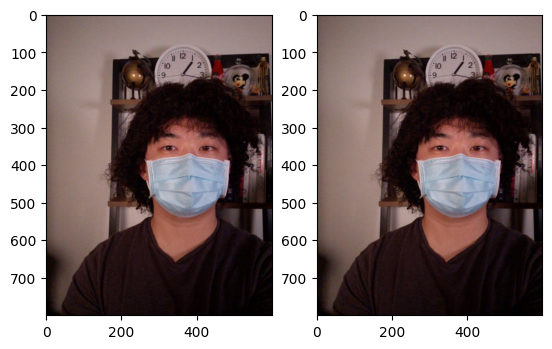

23
bad pts:  3292


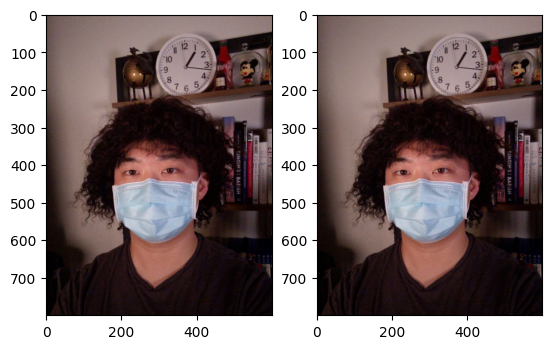

31
bad pts:  3292


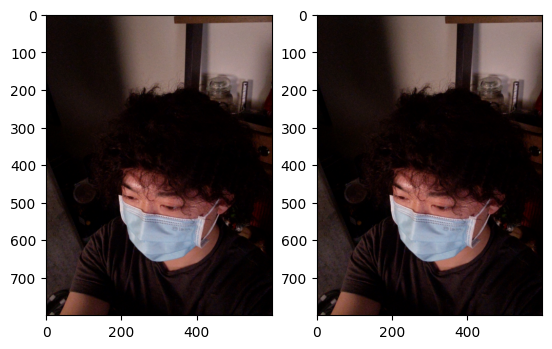

In [10]:
# 3D PTS Projection from IPYNB nerfies projection
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import json

capture_name = 'curls'
root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
# root_dir = '/ubc/cs/research/kmyi/svsamban/research/data-nerfies' + '/' + capture_name

directory = root_dir 
scale = 1.
if 'data-nerfies' in root_dir:
    scale = 2.
points = np.load(directory+'/points.npy',allow_pickle=True)
y = json.load(open(directory+'/scene.json'))
directory_cam = directory+'/camera'

blue = {}
i = 0
# iterate over files in that directory
for key in [18,23,31]:
    file = open(directory_cam+'/'+str(key).zfill(6)+'.json')
    cam = json.load(file)

    points = points.reshape((-1, 3))
    points_homog = np.concatenate((points.T, np.ones_like(points)[:,0].reshape(1,-1)), 0)


    T = np.eye(4)
    T[:3,3] = -1*np.array(cam['position'])
    R = np.eye(4)
    R[:3,:3] = np.array(cam['orientation'])
    V = np.matmul(R,T)

    K = np.eye(4)
    K[0][0] = cam['focal_length']/scale
    K[0][1] = cam['skew']
    K[0][2] = cam['principal_point'][0]/scale
    K[1][1] = cam['focal_length'] * cam['pixel_aspect_ratio']/scale
    K[1][2] = cam['principal_point'][1]/scale

    P = K @ V

    pixels =  P @ points_homog
    pixels = pixels.T

    # Get normalized local pixel positions.
    pixels = pixels / np.expand_dims(pixels[..., 3],axis=1)
    pixels = pixels / np.expand_dims(pixels[..., 2],axis=1)
    blue[key] = pixels


ii=0
print(blue.keys())
for id in sorted(blue.keys()):
    b = np.array(blue[id])

    # im2 = directory+'/rgb/2x/left1_'+str(id).zfill(6)+'.png'
    im2 = directory+'/rgb/1x/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2)
    shape = img2.shape[:2]
    # print(shape)
    new_shape = np.array([shape[1],shape[0]])
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(new_shape))
    img2og = img2.copy()
    bad = 0
    for i in range(len(b)):
        x1 = int(b[i,1]/(shape[0]/new_shape[1]))
        x2 = int(b[i,0]/(shape[0]/new_shape[1]))
        if x1 < 120 and x2 < 160 and x1 > -1 and x2 > -1:
            n = 2
            img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            # img2[x1,x2,:] = [0,0.,255.]
        else:
            bad = bad + 1
            pass

    print(id)
    print('bad pts: ', bad)
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()

In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np 

directory = 

coords_og = np.load(directory+'/points.npy',allow_pickle=True)
coords_filtered = coords_og
coords_thrownout = []
masks_used = 1
# iterate over files in that directory
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        key = int(filename[:6])
        cam = json.load(file)

        # load COLMAP points
        points = np.array(coords_filtered)
        pixels = project(points, cam)
        coords_filtered = []
        coords_thrownout = []

        # load rgb
        im = mpimg.imread(directory+'/rgb/1x/'+str(key).zfill(6)+'.png')
        shape = im.shape
        scale = 1.0
        new_shape = (int(shape[1]/scale),int(shape[0]/scale))
        im = np.array(Image.fromarray((im*255).astype(np.uint8)).resize(new_shape))
        imgog = im.copy()
        
        # load mask 
        if capture_name == 'curls':
            mask = mpimg.imread(directory+'/rgb/mask/'+str(key).zfill(6)+'_mask.png')
        else:
            mask = mpimg.imread(directory+'/rgb/mask/'+str(key).zfill(6)+'.png')
            mask = np.sum(mask,axis=-1)/3.0
        mask = np.array(Image.fromarray((mask*255).astype(np.uint8)).resize(new_shape))
        
        bad = 0
        for i in range(len(pixels)):
            x1 = int(pixels[i,1]/scale)
            x2 = int(pixels[i,0]/scale)
            dot_size = 20
            if x1 < new_shape[1] and x2 < new_shape[0] and x1 > -1 and x2 > -1:
                if mask[x1,x2] > 100 :
                    im[x1-dot_size:x1,x2-dot_size:x2,:] = [0,255,0]
                    # print('in')
                    coords_filtered.append(points[i])
                else:
                    im[x1-dot_size:x1,x2-dot_size:x2,:] = [255,0,0]

                    coords_thrownout.append(points[i])
                    # print('out')
            else :
                bad = bad+1
                coords_filtered.append(points[i])

        # pixels_thrownout = project(coords_thrownout, cam)
        # for k in range(len(pixels_thrownout)):
        #     x2,x1 = pixels_thrownout[k]
        #     x1 = int(x1)
        #     x2 = int(x2)
        #     im[x1-dot_size:x1,x2-dot_size:x2,:] = [255,0,0]

        # plt.imshow(mask)
        # plt.imshow(im)

        # plt.imshow(img)
        # fig=plt.figure()
        # fig.add_subplot(1,3,3)
        # plt.imshow(imgog)
        # fig.add_subplot(1,3,2)
        # plt.imshow(im)
        # fig.add_subplot(1,1,1)
        # plt.imshow(mask)
        # plt.show()
        
        print('points preserved:', len(coords_filtered), '... throwing out ', len(coords_thrownout), 'points and ', bad, ' points out of range')
        masks_used = masks_used + 1
        if masks_used > max_masks_used:
            pixels_thrownout = project(coords_thrownout, cam)
            for k in range(len(pixels_thrownout)):
                x2,x1 = pixels_thrownout[k]
                x1 = int(x1)
                x2 = int(x2)
                im[x1-dot_size:x1,x2-dot_size:x2,:] = [255,0,0]

            plt.imshow(mask)
            plt.imshow(im)

            # plt.imshow(img)
            fig=plt.figure()
            fig.add_subplot(1,3,3)
            plt.imshow(imgog)
            fig.add_subplot(1,3,2)
            plt.imshow(im)
            fig.add_subplot(1,3,1)
            plt.imshow(mask)
            plt.show()
            break

NameError: name 'np' is not defined

## Training

 * You are now ready to train a Nerfie or a MetaNLR++!
 * Head over to the [training Colab](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb) for a basic demo.